### Selecting columns, viualizing

In [16]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import itertools

In [17]:
data = pd.read_csv("data_clean.csv")

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110155 entries, 0 to 110154
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   tconst                       110155 non-null  object 
 1   titleType                    110155 non-null  object 
 2   primaryTitle                 110155 non-null  object 
 3   originalTitle                110155 non-null  object 
 4   isAdult                      110155 non-null  int64  
 5   startYear                    110155 non-null  object 
 6   endYear                      110155 non-null  object 
 7   runtimeMinutes               110155 non-null  object 
 8   genres                       110155 non-null  object 
 9   averageRating                110155 non-null  float64
 10  numVotes                     110155 non-null  int64  
 11  Budget                       26636 non-null   float64
 12  Gross US & Canada            18139 non-null   float64
 13 

In [19]:
data["Critic reviews"] = data["Critic reviews"].fillna(0)
data["User reviews"] = data["User reviews"].fillna(0)

data["isAdult2"] = data.apply(lambda row: int("Adult" in row["genres"]), axis=1)
print(len(data[data["isAdult"] != data["isAdult2"]]))  # We use the one based on the genres

# tconst was only required for joins
# titleType is only films for us, we filtered them
# we do not use the titles as predictors
# endYear is None for all films
# isAdult will be added back in a consistent format later on
data = data.drop(columns=["tconst", "titleType", "primaryTitle", "originalTitle", "endYear", "isAdult", "isAdult2", "Opening weekend US & Canada", "Gross US & Canada"])
data = data.dropna()

52


In [20]:
genre_list = data["genres"].unique().tolist()
for i, entry in enumerate(genre_list):
    genre_list[i] = entry.split(",")

genre_set = set(itertools.chain(*genre_list))
print(genre_set)
# Here short is a weird category, as there is also a short category in the titleType column, where we only
# kept films. Here the IMDb database is a bit inconsistent.

{'Thriller', 'Comedy', 'Music', 'Sport', 'Animation', 'Romance', 'Sci-Fi', 'Horror', 'News', 'Crime', 'Musical', 'History', 'Documentary', 'Drama', 'Adventure', 'War', 'Family', 'Mystery', 'Film-Noir', 'Action', 'Western', 'Fantasy', 'Biography'}


In [21]:
for genre in genre_set:
    print(genre, end=" ")
    data[f"is{genre}"] = data.apply(lambda row: int(genre in row["genres"]), axis=1)

Thriller Comedy Music Sport Animation Romance Sci-Fi Horror News Crime Musical History Documentary Drama Adventure War Family Mystery Film-Noir Action Western Fantasy Biography 

In [22]:
results = []
for genre in genre_set:
    # print(genre, data[f"is{genre}"].sum())
    results.append(data[f"is{genre}"].sum())

sum_results = sum(results)
for genre in genre_set:
    print(genre, data[f"is{genre}"].sum() / sum_results * 100, "%")

Thriller 6.584846872862679 %
Comedy 14.36279352534387 %
Music 1.740253818679231 %
Sport 0.9081237176077209 %
Animation 1.9606353066342428 %
Romance 6.706436659320617 %
Sci-Fi 2.5229880690022037 %
Horror 4.3202371000835935 %
News 0.022798084960863288 %
Crime 7.504369632950832 %
Musical 0.49775818831218177 %
History 1.4590774374952504 %
Documentary 1.0487119081997112 %
Drama 21.730374648529523 %
Adventure 6.6874382551865645 %
War 0.8625275476859944 %
Family 2.2494110494718447 %
Mystery 3.480507637358462 %
Film-Noir 0.08359297818983205 %
Action 9.514400790333612 %
Western 0.35716999772019153 %
Fantasy 2.807964131012995 %
Biography 2.587582643057983 %


In [23]:
# We drop categories that do not have enough samples to be representative
# We draw the line at 1% of the shares
# We also drop writers and directors. These are interesting features,
# but having them as binary columns would be infeasible.
# Genres are added as binary predictors, thus the genres column is no longer used.
data = data.drop(columns=["isMusical", "isFilm-Noir", "isNews", "isSport", "genres"])

def unrated_to_not_rated(row):
    if row["Rating"] == "Unrated":
        return "Not Rated"
    else:
        return row["Rating"]

data["Rating"] = data.apply(unrated_to_not_rated, axis=1)

In [24]:
for rating in data.Rating.unique():
    print(rating, end=" ")
    data[f"is{rating}"] = data.apply(lambda row: int(row["Rating"] == rating), axis=1)
data.to_csv("sanity.csv")

Not Rated Passed PG-13 G Approved GP PG M/PG R TV-MA M X NC-17 TV-14 TV-G TV-PG Open TV-Y7-FV TV-Y7 

In [25]:
results = []
for rating in data.Rating.unique():
    # print(rating, data[f"is{rating}"].sum())
    results.append(data[f"is{rating}"].sum())

sum_results = sum(results)

for rating in data.Rating.unique():
    print(rating, data[f"is{rating}"].sum() / sum_results * 100, "%")

# Not needed anymore, we have the binary version
data = data.drop(columns=["Rating"])

Not Rated 16.824465063434957 %
Passed 0.5017989017231584 %
PG-13 22.24010604052263 %
G 2.3385722401060405 %
Approved 0.6154137473963265 %
GP 0.08521113425487596 %
PG 13.491762923688697 %
M/PG 0.02840371141829199 %
R 41.052830903238025 %
TV-MA 1.202423783374361 %
M 0.01893580761219466 %
X 0.02840371141829199 %
NC-17 0.20829388373414126 %
TV-14 0.8237076311304677 %
TV-G 0.11361484567316796 %
TV-PG 0.3597803446316985 %
Open 0.00946790380609733 %
TV-Y7-FV 0.00946790380609733 %
TV-Y7 0.04733951903048665 %


In [11]:
# Again, we drop ratings that do not have enough samples to be representative
# We draw the line at 1% of the shares
data = data.drop(columns=[
    "isGP", "isPassed", "isApproved", "isGP", "isM/PG", "isM",
    "isX", "isNC-17", "isTV-14", "isTV-G", "isTV-PG",
    "isOpen", "isTV-Y7-FV", "isTV-Y7"]
)

In [12]:
def clean_unknowns(row, column):
    if row[column] == "\\N":
        return None
    else:
        return row[column]

def clean_reviews(row, column):
    if isinstance(row[column], str) and "K" in row[column]:
        # print(row[column], end=" -> ")
        if "." in row[column]:
            # print(int(row[column][:-3]) * 1000 + int(row[column][-2]) * 100)
            return int(row[column][:-3]) * 1000 + int(row[column][-2]) * 100
        else:
            # print(int(row[column][:-1]) * 1000)
            return int(row[column][:-1]) * 1000
    else:
        return row[column]

# Just an example of problematic data types
# print("Problematic form")
# print(data.startYear.unique())
# print(data.runtimeMinutes.unique())
# print(data["User reviews"].unique())
# print(data["Critic reviews"].unique())

data["startYear"] = data.apply(lambda row: clean_unknowns(row, "startYear"), axis=1)
data["runtimeMinutes"] = data.apply(lambda row: clean_unknowns(row, "runtimeMinutes"), axis=1)
data["User reviews"] = data.apply(lambda row: clean_reviews(row, "User reviews"), axis=1)
data["Critic reviews"] = data.apply(lambda row: clean_reviews(row, "Critic reviews"), axis=1)

for column in ["startYear", "runtimeMinutes", "User reviews", "Critic reviews"]:
    data[column] = pd.to_numeric(data[column])

# print("Resolved form")
# print(data.startYear.unique())
# print(data.runtimeMinutes.unique())
# print(data["User reviews"].unique())
# print(data["Critic reviews"].unique())

In [26]:
print("All features present:")
filtered = data.dropna()
print(len(filtered))
print()

All features present:
10562



In [29]:
filtered.corr().style.background_gradient(cmap='coolwarm')

,averageRating,numVotes,Budget,Gross worldwide,isThriller,isComedy,isMusic,isAnimation,isRomance,isSci-Fi,isHorror,isCrime,isHistory,isDocumentary,isDrama,isAdventure,isWar,isFamily,isMystery,isAction,isWestern,isFantasy,isBiography,isNot Rated,isPassed,isPG-13,isG,isApproved,isGP,isPG,isM/PG,isR,isTV-MA,isM,isX,isNC-17,isTV-14,isTV-G,isTV-PG,isOpen,isTV-Y7-FV,isTV-Y7
averageRating,1.000000,0.377936,0.095791,0.210008,-0.086248,-0.117211,0.037640,0.019196,0.018034,-0.038465,-0.195235,0.032985,0.092044,0.114240,0.266948,-0.026922,0.074514,-0.063359,-0.005095,-0.092814,0.023100,-0.051033,0.156283,-0.009409,0.086521,-0.035888,0.044795,0.077741,0.025027,-0.028132,0.011326,0.023605,-0.030194,0.013067,0.023802,0.020707,-0.013392,-0.004642,-0.003077,0.006538,0.002037,-0.009539
numVotes,0.377936,1.000000,0.482263,0.603811,0.006589,-0.060488,-0.040237,0.032794,-0.064572,0.160302,-0.031783,0.010013,-0.022566,-0.067302,-0.057002,0.172899,-0.004278,-0.019361,0.024755,0.143369,-0.001119,0.056180,0.006405,-0.178357,-0.009214,0.147527,0.015699,-0.003703,-0.007860,-0.004061,-0.001441,0.032318,-0.043537,-0.002120,0.028581,-0.004313,-0.039864,-0.014761,-0.023862,-0.004301,-0.004471,-0.009901
Budget,0.095791,0.482263,1.000000,0.617877,-0.027466,-0.001235,-0.046347,0.158217,-0.078424,0.186600,-0.117544,-0.033099,0.000557,-0.106829,-0.186244,0.412365,-0.019611,0.074750,-0.037670,0.289672,0.002847,0.121370,-0.025148,-0.260555,-0.019064,0.283388,0.072009,-0.013300,-0.004886,0.149275,0.005221,-0.129762,-0.062286,0.001096,-0.002035,-0.023011,-0.056912,-0.019209,-0.033470,-0.006801,-0.001251,-0.011672
Gross worldwide,0.210008,0.603811,0.617877,1.000000,-0.023754,0.002667,-0.024625,0.152249,-0.048262,0.119246,-0.057679,-0.059265,-0.014252,-0.056873,-0.146848,0.301996,-0.022851,0.061009,-0.030942,0.159052,-0.007663,0.084354,-0.034011,-0.162683,0.028070,0.168255,0.098453,-0.001292,-0.002439,0.117650,-0.006613,-0.114972,-0.036404,-0.001078,0.007391,-0.013038,-0.034287,-0.012936,-0.018198,-0.003432,-0.003810,-0.008261
isThriller,-0.086248,0.006589,-0.027466,-0.023754,1.000000,-0.288628,-0.091815,-0.100409,-0.160075,0.013747,0.188429,0.118640,-0.064202,-0.072573,-0.142821,-0.123334,-0.055083,-0.106847,0.143256,0.091458,-0.028373,-0.098469,-0.103819,-0.002438,-0.027845,-0.066037,-0.063483,-0.015250,0.004585,-0.130066,0.022875,0.178021,0.007417,-0.006097,0.007703,-0.014634,-0.009263,-0.014942,-0.018083,-0.004311,-0.004311,-0.009642
isComedy,-0.117211,-0.060488,-0.001235,0.002667,-0.288628,1.000000,0.023358,0.107501,0.148406,-0.117691,-0.157982,-0.095649,-0.134459,-0.098769,-0.246447,0.005363,-0.080681,0.066228,-0.176023,-0.181184,-0.045510,-0.011984,-0.134072,-0.075481,-0.008296,0.052871,0.058290,-0.023392,-0.015033,0.156097,-0.012584,-0.101495,-0.004442,-0.010274,-0.012584,-0.016780,-0.013409,-0.007590,-0.001978,0.013034,-0.007265,0.010991
isMusic,0.037640,-0.040237,-0.046347,-0.024625,-0.091815,0.023358,1.000000,-0.039626,0.030483,-0.051313,-0.058949,-0.066338,-0.021486,0.078771,0.040123,-0.088966,-0.021937,-0.013482,-0.060653,-0.113218,-0.020175,-0.032884,0.053886,-0.001312,0.030932,0.021396,0.028574,0.018910,-0.006218,0.011168,-0.003589,-0.037820,0.002102,-0.002930,-0.003589,0.000469,-0.003974,-0.007180,-0.012793,-0.002072,-0.002072,-0.004633
isAnimation,0.019196,0.032794,0.158217,0.152249,-0.100409,0.107501,-0.039626,1.000000,-0.100338,-0.042414,-0.077300,-0.101932,-0.044021,-0.034371,-0.189867,0.381896,-0.030559,0.099443,-0.066718,-0.034423,-0.021476,-0.015674,-0.046979,-0.042050,-0.016095,-0.094800,0.325312,-0.012218,-0.006619,0.265331,-0.003820,-0.175741,-0.020973,-0.003119,-0.003820,-0.010354,0.003643,0.031470,0.067074,-0.002205,0.042936,0.055642
isRomance,0.018034,-0.064572,-0.078424,-0.048262,-0.160075,0.148406,0.030483,-0.100338,1.000000,-0.079421,-0.138382,-0.159492,-0.053108,-0.071782,0.140219,-0.166244,-0.005134,-0.080463,-0.085730,-0.213294,-0.015424,-0.051229,-0.064893,-0.004038,0.040022,0.088770,-0.055879,0.032898,0.013012,-0.046153,-0.007550,

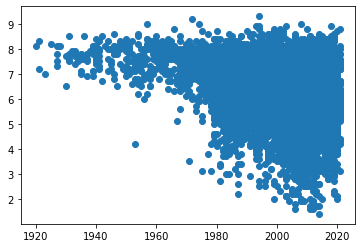

In [28]:
fig, ax = plt.subplots()
ax.scatter(filtered["startYear"], filtered["averageRating"])